## Proyecto jupiter - Introducción
La empresa Pontia Bank S.L. necesita desarrollar un sistema de detección de transacciones fraudulentas. Esta compañía, tramita miles de transacciones diarias de todos sus clientes entre las cuales se quiere diferenciar entre las que son fraudulentas de las que no lo son.
Se deben presentar al menos dos algoritmos de los cuales al menos uno debe ser de Deep Learning y otro no.


## 1. Importar librerias

In [1]:
#Librerias basicas
import pandas as pd
import numpy as np

#Librerias de visualizacion
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline


#Librerias de ML
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler 
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

#Librerias de Metricas 
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#Libreria para guardar y cargar nuestros modelos
from joblib import dump
from joblib import load

import warnings
warnings.filterwarnings("ignore")

## 2. Carga del dataset

In [2]:
data = pd.read_csv("df_completo.csv")

In [4]:
data.shape

(6362520, 12)

## 3. Selección del algoritmo:
¿Qué queremos conseguir con el modelo? clasificar datos en dos clases: fraudes y no fraudes

¿Con qué datos contamos para resolver el problema? Datos etiquetados

Conclusión: algoritmo de aprendizaje supervisado, clasificación

## 4. Feature engineering

## 4.1 Feature creation

Como vimos en el EDA que solo existen transacciones fraudulentas del tipo TRANSFER Y CASH_OUT, vamos a realizar nuestros modelos solo con las transacciones de estos tipos.

In [5]:
filtro = (data['tipo'] == 'TRANSFER')| (data['tipo']  == 'CASH_OUT')

In [6]:
df =  data[filtro]

In [7]:
df.columns

Index(['t_id', 'tipo', 'fecha_final', 'id_cliente_origen',
       'balance_prev_origen', 'balance_post_origen', 'id_cliente_destino',
       'balance_prev_destino', 'balance_post_destino', 'cuantia',
       'mensaje_alarma', 'es_fraude'],
      dtype='object')

Como vimos en el EDA que la fecha no se vinculaba a los fraudes vamos a eliminar dicho atributo, tambien eliminaremos las columnas que son Identificadores unicos, tanto de clientes como de las transacciones.

In [8]:
df_1=df.copy()

In [9]:
df_1 = df_1.drop(['id_cliente_origen','id_cliente_destino','fecha_final','t_id'], axis=1)

Creamos nuevos atributos para entrenar nuestros modelos y obtener mejores resultados

In [10]:
df_1['diff_origen'] = abs(df_1['balance_post_origen']-df_1['balance_prev_origen'].astype(int))

In [11]:
df_1['diff_destino'] = abs(df_1['balance_post_destino']-df_1['balance_prev_destino'].astype(int))

In [12]:
df_1.head(10)

,tipo,balance_prev_origen,balance_post_origen,balance_prev_destino,balance_post_destino,cuantia,mensaje_alarma,es_fraude,diff_origen,diff_destino
2,TRANSFER,181.00,0.0,0.0,0.00,181.00,False,True,181.0,0.00
3,CASH_OUT,181.00,0.0,21182.0,0.00,181.00,False,True,181.0,21182.00
15,CASH_OUT,15325.00,0.0,5083.0,51513.44,229133.94,False,False,15325.0,46430.44
19,TRANSFER,705.00,0.0,22425.0,0.00,215310.30,False,False,705.0,22425.00
24,TRANSFER,10835.00,0.0,6267.0,2719172.89,311685.89,False,False,10835.0,2712905.89
42,CASH_OUT,26845.41,0.0,288800.0,2415.16,110414.71,False,False,26845.0,286384.84
47,CASH_OUT,1942.02,0.0,70253.0,64106.18,56953.90,False,False,1942.0,6146.82
48,CASH_OUT,0.00,0.0,652637.0,6453430.91,5346.89,False,False,0.0,5800793.91
51,CASH_OUT,20411.53,0.0,25742.0,0.00,23261.30,False,False,20411.0,25742.00
58,TRANSFER,79114.00,16503.2,517.0,8383.29,62610.80,False,False,62610.8,7866.29


In [13]:
df_1.columns

Index(['tipo', 'balance_prev_origen', 'balance_post_origen',
       'balance_prev_destino', 'balance_post_destino', 'cuantia',
       'mensaje_alarma', 'es_fraude', 'diff_origen', 'diff_destino'],
      dtype='object')

In [14]:
df['es_fraude'] = df['es_fraude'].astype(int)

In [15]:
df['mensaje_alarma'] = df['mensaje_alarma'].astype(int)

## 4.2 Feature transformation - Transformaciones categóricas

In [16]:
df2 = pd.get_dummies(df_1)

In [17]:
df2.head(2)

,balance_prev_origen,balance_post_origen,balance_prev_destino,balance_post_destino,cuantia,mensaje_alarma,es_fraude,diff_origen,diff_destino,tipo_CASH_OUT,tipo_TRANSFER
2,181.0,0.0,0.0,0.0,181.0,False,True,181.0,0.0,0,1
3,181.0,0.0,21182.0,0.0,181.0,False,True,181.0,21182.0,1,0


In [18]:
df2.columns

Index(['balance_prev_origen', 'balance_post_origen', 'balance_prev_destino',
       'balance_post_destino', 'cuantia', 'mensaje_alarma', 'es_fraude',
       'diff_origen', 'diff_destino', 'tipo_CASH_OUT', 'tipo_TRANSFER'],
      dtype='object')

In [19]:
df2.shape

(2770360, 11)

Separo variables de target 

In [20]:
X = df2.drop('es_fraude', 1)      

In [21]:
y = df2['es_fraude']   

## 4.3 Feature Selection

Selección de características basada en impurezas/importancia de características

In [41]:
model = RandomForestClassifier(n_estimators=200, random_state=0)
model.fit(X,y)

RandomForestClassifier(n_estimators=200, random_state=0)

<AxesSubplot:>

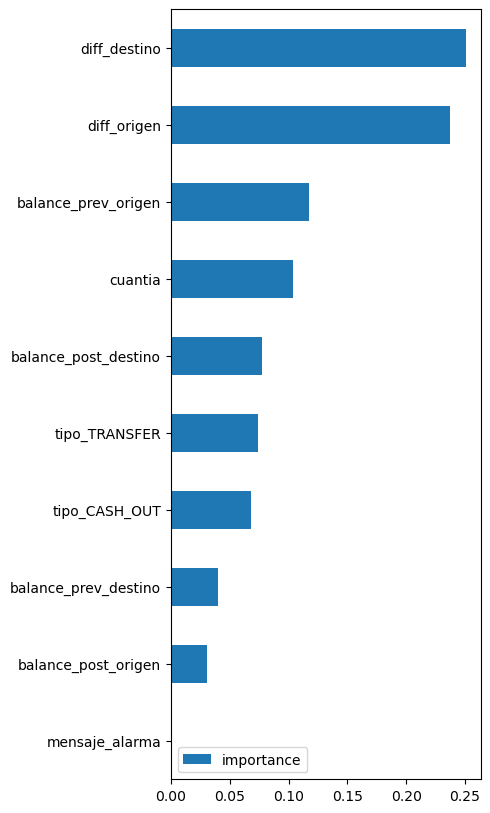

In [42]:
importances = model.feature_importances_

# visualizacion
cols = X.columns
(pd.DataFrame(importances, cols, columns = ['importance'])
 .sort_values(by='importance', ascending=True)
 .plot(kind='barh', figsize=(4,10)))

Variables seleccionadas para el modelo:

'diff_origen'

'diff_destino'

'balance_prev_origen'

'balance_post_destino'

'cuantia'

'tipo_CASH_OUT'

'tipo_TRANSFER'

## 5. Data Splitting

In [22]:
# Eliminamos la variables que no se usaran para el modelo 
df3 = df2.drop(['balance_post_origen','balance_prev_destino','mensaje_alarma' ], axis=1)

In [23]:
X1 = df3.drop('es_fraude', 1)    

In [24]:
X1.shape

(2770360, 7)

In [25]:
y1 = df['es_fraude']   

In [26]:
y1.shape

(2770360,)

## 6. Lidiando con el desequilibrio

El conjunto de datos está desequilibrado, necesitamos equilibrarlo para obtener un mejor modelo.
Un primer enfoque para tratar con datos desequilibrados es equilibrarlos descartando la clase mayoritaria antes de aplicar un algoritmo de ML.Otro enfoque podría ser sobremuestrear la clase minoritaria, por ejemplo, mediante la técnica de sobremuestreo SMOTE contenida en la biblioteca 'imblearn'. 
La tecnica de submuestreo aleatorio (RandomUnderSampler) elimina aleatoriamente muestras de la  clase mayoritaria, con o sin reemplazo, como desventaja puede aumentar la varianza del clasificador y puede descartar potencialmente muestras utiles o importantes. Por otro lado, la ventaja que ofrece es que al reducir el tamaño del conjunto de datos, el tiempo de computacion y el uso de memoria tambien disminuyen al trabajar con la nueva muestra. La tecnica de sobremuestreo añade muestras a la clase minoritaria con el fin de equilibrar la diferencia entre clases. La tecnica SMOTE (Synthetic Minority Over-sampling Technique) crea puntos sinteticos (muestras) de la clase minoritaria para alcanzar un equilibrio equitativo entre la clase minoritaria y la mayoritaria. 
Para este proyecto academico en particular, dado el tamaño del dataset(6 millones de registros) optamos por utilizar la tecnica RandomUnderSampler con el objetivo de disminuir el tiempo y el uso de memoria al ejecutar los algoritmos de ML en nuestro ordenador. 

In [27]:
y1.value_counts()

0    2762151
1       8209
Name: es_fraude, dtype: int64

In [28]:
sm = RandomUnderSampler(random_state=42)
X_under, y_under = sm.fit_resample(X1, y1)



In [29]:
print(X_under.shape)
print(y_under.shape)

(16418, 7)
(16418,)


<AxesSubplot:title={'center':'Distribución de etiquetas después del submuestreo'}>

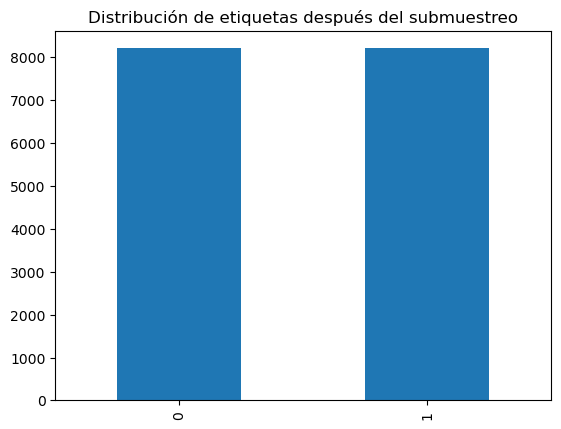

In [30]:
#Pintamos la nueva distribución 
y_under.value_counts().plot(kind='bar', title='Distribución de etiquetas después del submuestreo')

## 7. División de conjuntos de datos en train y test

In [31]:
X_train , X_test , y_train , y_test = train_test_split(X_under,y_under, test_size=0.2 , random_state=42)

In [32]:
print("Ejemplos usados para entrenar: ", len(X_train))
print("Ejemplos usados para test: ", len(X_test))

Ejemplos usados para entrenar:  13134
Ejemplos usados para test:  3284


## 8. Data Scalling

Recopilamos todas las características numéricas y aplicamos la función StandardScaler() que transforma la distribución para que la media se convierta en 0 y la desviación estándar se convierta en 1

In [35]:
#Estandarizamos las columnas numericas 
col_names=['balance_prev_origen', 'balance_post_destino', 'cuantia', 'diff_origen',
       'diff_destino']
features_train = X_train[col_names]
features_test = X_test[col_names]
scaler = StandardScaler().fit(features_train.values)
features_train = scaler.transform(features_train.values)
features_test = scaler.transform(features_test.values)
X_train[col_names] = features_train
X_test[col_names] = features_test

## 9. Model Building

Se aplicaran:
    
     1)Un algoritmo de clasificacion, se medira la recall de los algoritmos: KNN, regresion logistica, Naive Bayes y SVC y se entrenara aquel con el cual se obtenga la recall mas alta. 
     2)Dos algoritmos de tipo ensemble, Random forest y XGBoost
     3)Un algoritmo de Deep Learnig 
     

Al final del documento se uniran las metricas de las propuestas para evaluar los resultados y obtener conclusiones.

Para este caso en particular las «falsas alarmas» (falsos positivos) no nos preocupan, y lo que queremos evitar son los falsos negativos, por lo tanto, nos interesa una mayor sensibilidad o recall. (VP / + FN VP).
Tambien nos interesa la tasa de falsos negativos, llamada también tasa de error, es la probabilidad de que la prueba pase por alto un verdadero positivo. Se calcula como FN / FN + VP, donde FN es el número de falsos negativos y VP es el número de verdaderos positivos. 

## 9.1 Buscando el algoritmo con mejor Recall 

In [36]:
logreg_cv = LogisticRegression(random_state=123)
knn_cv=KNeighborsClassifier()
svc_cv=SVC(kernel='linear',random_state=123)
nb_cv=GaussianNB()
cv_dict = {0: 'Logistic Regression', 1:'KNN',2:'SVC',3:'Naive Bayes'}
cv_models=[logreg_cv,knn_cv,svc_cv,nb_cv]


for i,model in enumerate(cv_models):
    print("{} Recall: {}".format(cv_dict[i],cross_val_score(model, X_train, y_train, cv=10, scoring ='recall').mean()))

Logistic Regression Recall: 0.8577061755206593
KNN Recall: 0.9640443442105655
SVC Recall: 0.8683701785647994
Naive Bayes Recall: 0.6329943479229312


## 9.2 KNN

In [37]:
# Definir el modelo de clasificación
neigh = KNeighborsClassifier(5)

# Entrenarlo
neigh.fit(X_train, y_train)

# Obtener las predicciones para el conjunto de datos de testeo
y_est = neigh.predict(X_test) 

In [38]:
# Obtener las metricas
MSE_tst = mean_squared_error(y_test, y_est)
accuracy = accuracy_score(y_test,y_est)
recall = recall_score(y_test, y_est)
precision= precision_score(y_test, y_est)

# Imprimimos las metricas
print('MSE : ' + str(MSE_tst))
print('Accuracy: ' + str(accuracy))
print('recall: ' + str(recall))  
print('precision: ' + str(precision))

MSE : 0.04110840438489647
Accuracy: 0.9588915956151035
recall: 0.9683890577507599
precision: 0.9504773269689738


Matriz de confusion KNN


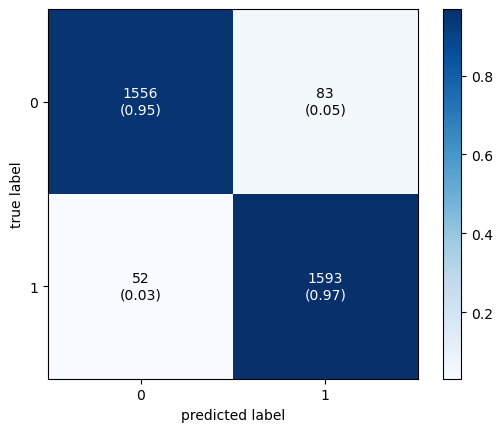

In [39]:
print('Matriz de confusion KNN')

cm1 = confusion_matrix(y_test,y_est)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

- 95% de los casos, predijo que no era fraude y era cierto.  (Verdadero Negativo)
- 3% de los casos predijo que no era fraude y era. (Falsos Negativos)
- 5% de los casos predijo que era fraude y no era.(Falso positivo)
- 97% de los casos que son fraude fueron predichos como fraude. (Verdaderos Positivos)

## 9.2.1 ¿Cuál es el número óptimo de vecinos?
Apliquemos mejor validación cruzada con GridSearchCV para obtener el valor óptimo

In [40]:
k_max =20
rang_K = np.arange(1, k_max+1)
tuned_parameters = [{'n_neighbors': rang_K}]
nfold = 5

# Definir el modelo de clasificacion KNN con validación cruzada y entrenarlo
# Configurar CV para que devuelva las puntuaciones de entrenamiento
neigh_CV = GridSearchCV(KNeighborsClassifier(), 
                        tuned_parameters, 
                        cv=nfold, 
                        return_train_score=True).fit(X_train, y_train)

# Obtener las predicciones para el conjunto de datos de testeo
y_est1 = neigh_CV.predict(X_test) 


#Obtener el mejor parametro 
K_CV = neigh_CV.best_params_['n_neighbors']

print('Selected value of k: ' + str(K_CV))

Selected value of k: 3


In [41]:
# Obtener las metricas
MSE_tst_knn = mean_squared_error(y_test, y_est1)
accuracy_knn = accuracy_score(y_test,y_est1)
recall_knn = recall_score(y_test, y_est1)
precision_knn= precision_score(y_test, y_est1)

# Imprimimos las metricas
print('MSE: ' + str(MSE_tst_knn))
print('Accuracy: ' + str(accuracy_knn))
print('recall: ' + str(recall_knn))  
print('precision: ' + str(precision_knn))

MSE: 0.04080389768574909
Accuracy: 0.9591961023142509
recall: 0.9702127659574468
precision: 0.9494348602022605


Matriz de confusion KNN - número óptimo de vecinos


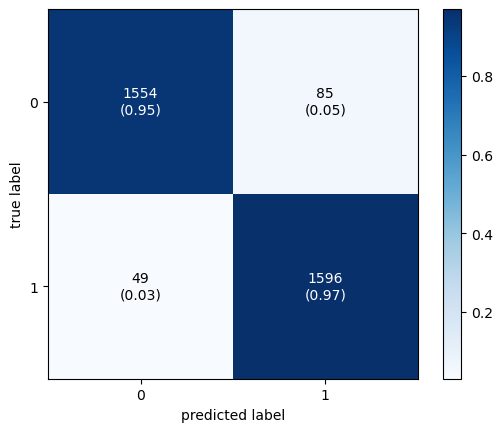

In [42]:
print('Matriz de confusion KNN - número óptimo de vecinos')

cm1 = confusion_matrix(y_test,y_est1)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

- 95% de los casos, predijo que no era fraude y era cierto. (Verdadero Negativo)
- 3% de los casos predijo que no era fraude y era. (Falsos Negativos)
- 5% de los casos predijo que era fraude y no era.(Falso positivo)
- 97% de los casos que son fraude fueron predichos como fraude. (Verdaderos Positivos)

In [46]:
def plot_roc_curve(fpr, tpr, roc_auc):
    figsize=(6, 4)
    plt.plot(fpr, tpr, color='orange', label='ROC curve of class (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Base estimator')
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title('Curva de Roc')
    plt.legend()
    plt.show()

AUC:  0.9783545456399947


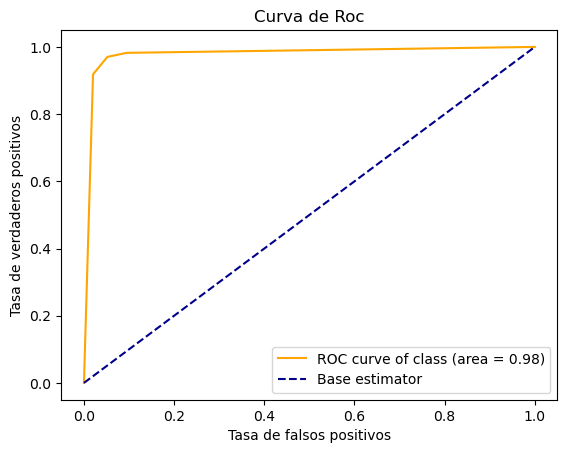

In [47]:
fpr, tpr, thresholds = roc_curve(y_test, neigh_CV.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

print("AUC: ", roc_auc)
plot_roc_curve(fpr, tpr, roc_auc)

La curva ROC compara la Tasa de Verdaderos Positivos y la Tasa de Falsos Positivos, esta se usa para medir el rendimiento (o
la efectividad, en su mas amplio sentido) del clasificador a traves de distintos metodos, en este caso se emplea el  AUC - ROC (area bajo la curva ROC).
El ROC es una curva de probabilidad y el AUC representa el grado de separabilidad, este indica en que medida el modelo es capaz de distinguir entre clases. Respecto a la generacion de la curva, cuanto mas alto sea el AUC mejor sera el modelo a la hora de predecir no fraudes (0s) como no fraudes (0s) y fraudes (1s) como fraudes (1s).
Cuanto más abraza la curva la esquina superior izquierda del gráfico, mejor lo hace el modelo para clasificar los datos en categorías. Cuanto más cerca esté el AUC de 1, mejor será el modelo. Un modelo con un AUC igual a 0.5 no es mejor que un modelo que hace clasificaciones aleatorias.
En nuestro caso la AUC es del 97% por lo que podemos decir que performa de buena manera al distinguir entre las clases. 

In [48]:
dump(neigh_CV, 'knn.joblib') 

['knn.joblib']

## 9.3 Random Forest

In [49]:
# Aplico tuning de hyperparametros del modelo
rfc = RandomForestClassifier(n_estimators = 200, n_jobs  = -1, random_state = 123)

# Defino grid search
param_grid = { 
    'max_features': [ 'sqrt', 'log2'], 
    'max_depth' : [3,4], # Número máximo de niveles por Arbol.
    'criterion' :['gini', 'entropy'],
    'ccp_alpha': [0, 0.01]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(
        estimator  = rfc,
        param_grid = param_grid,
        scoring    = 'recall', 
        cv         = cv, 
        return_train_score = True
       )

grid_result = grid.fit(X_train, y_train)
# Sumarizo resultados
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.912710 using {'ccp_alpha': 0.01, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt'}


In [50]:
# Resultados
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False)

,param_ccp_alpha,param_criterion,param_max_depth,param_max_features,mean_test_score,std_test_score,mean_train_score,std_train_score
10,0.01,gini,4,sqrt,0.912710,0.012897,0.915279,0.007126
11,0.01,gini,4,log2,0.912710,0.012897,0.915279,0.007126
2,0,gini,4,sqrt,0.912202,0.013148,0.916074,0.007925
3,0,gini,4,log2,0.912202,0.013148,0.916074,0.007925
14,0.01,entropy,4,sqrt,0.896967,0.015478,0.898464,0.010800
15,0.01,entropy,4,log2,0.896967,0.015478,0.898464,0.010800
6,0,entropy,4,sqrt,0.896408,0.014130,0.898899,0.009791
7,0,entropy,4,log2,0.896408,0.014130,0.898899,0.009791
8,0.01,gini,3,sqrt,0.893918,0.013368,0.895203,0.007711
9,0.01,gini,3,log2,0.893918,0.013368,0.895203,0.007711


In [51]:
#Aplicamos los parametros obtenidos 
rfc1 = RandomForestClassifier(n_estimators = 200, n_jobs  = -1, random_state = 123,
                              ccp_alpha= 0.01, criterion = 'gini', max_depth= 4, max_features= 'sqrt')
# Entrenarlo
rfc1.fit(X_train, y_train)

# Obtener las predicciones para el conjunto de datos de testeo
y_est2 = rfc1.predict(X_test) 



In [52]:
# Obtener las metricas
MSE_tst_rf = mean_squared_error(y_test, y_est2)
accuracy_rf = accuracy_score(y_test,y_est2)
recall_rf = recall_score(y_test, y_est2)
precision_rf= precision_score(y_test, y_est2)

# Imprimimos las metricas
print('MSE : ' + str(MSE_tst_rf))
print('Accuracy: ' + str(accuracy_rf))
print('recall: ' + str(recall_rf))
print('precision: ' + str(precision_rf))

MSE : 0.08465286236297198
Accuracy: 0.915347137637028
recall: 0.8875379939209727
precision: 0.9401159047005795


Matriz de confusion para Random Forest


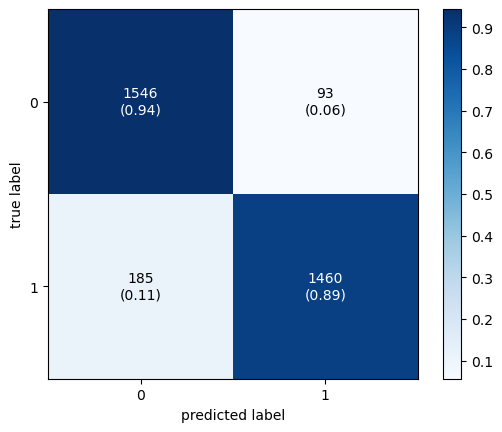

In [53]:
print('Matriz de confusion para Random Forest')

cm1 = confusion_matrix(y_test,y_est2)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

- 94% de los casos, predijo que no era fraude y era cierto. (Verdadero Negativo)
- 11% de los casos predijo que no era fraude y era. (Falsos Negativos)
- 6% de los casos predijo que era fraude y no era.(Falso positivo)
- 89% de los casos que son fraude fueron predichos como fraude. (Verdaderos Positivos)

AUC:  0.9833014051491847


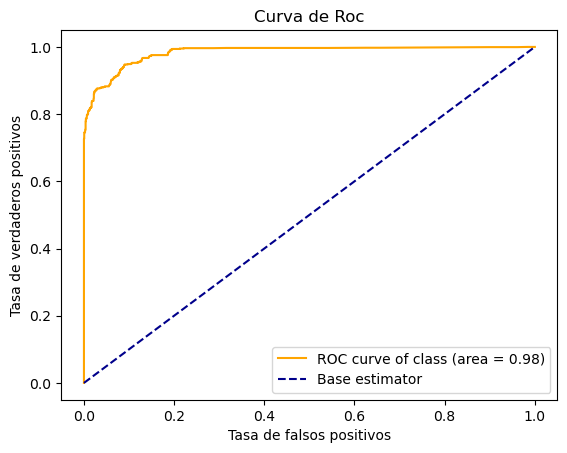

In [56]:
fpr, tpr, thresholds = roc_curve(y_test, rfc1.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

print("AUC: ", roc_auc)
plot_roc_curve(fpr, tpr, roc_auc)

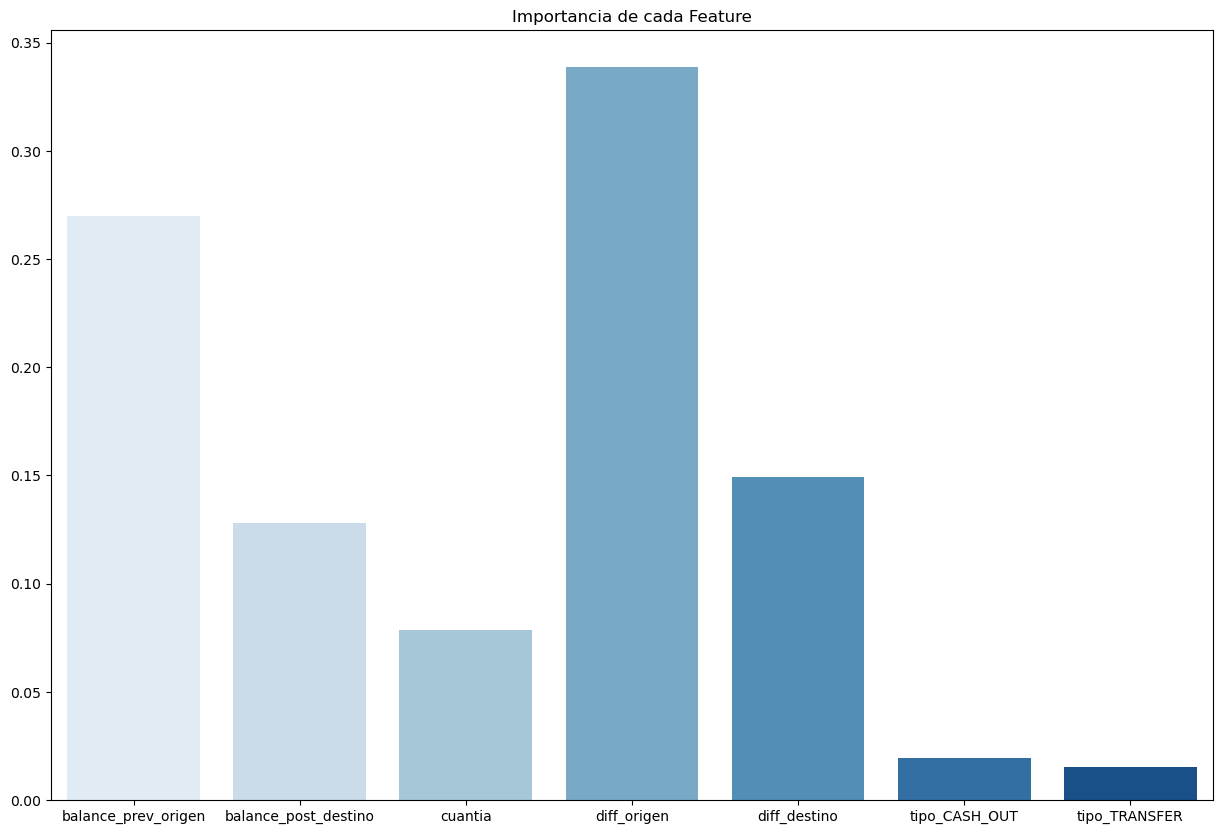

In [59]:
plt.figure(figsize=(15,10))
importances = rfc1.feature_importances_
columns = X_train.columns
sns.barplot(columns, importances, palette="Blues")
plt.title('Importancia de cada Feature')
plt.show()

In [55]:
dump(rfc1, 'rf.joblib') 

['rf.joblib']

## 9.4 XGBOOST

In [60]:
GBoost =  xgb.XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=2,  
                   subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
                   seed=42)
GBoost.fit(X_train, y_train)
# Obtener las predicciones para el conjunto de datos de testeo
y_est3 = GBoost.predict(X_test)

In [61]:
# Obtener las metricas
MSE_tst_xg = mean_squared_error(y_test, y_est3)
accuracy_xg = accuracy_score(y_test,y_est3)
recall_xg = recall_score(y_test, y_est3)
precision_xg = precision_score(y_test, y_est3)

# Imprimimos las metricas
print('MSE : ' + str(MSE_tst_xg))
print('Accuracy: ' + str(accuracy_xg))
print('recall: ' + str(recall_xg))
print('precision: ' + str(precision_xg))

MSE : 0.05176613885505481
Accuracy: 0.9482338611449452
recall: 0.9556231003039514
precision: 0.9418813660874775


Matriz de confusion  XGBOOST


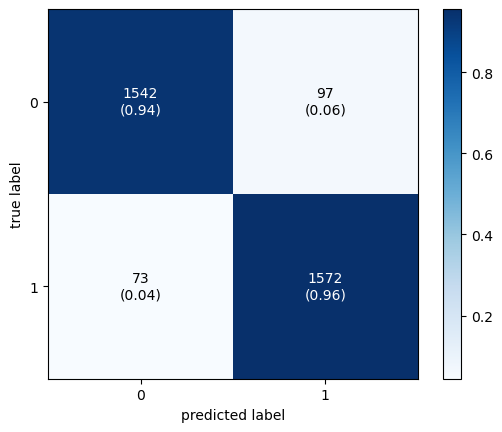

In [62]:
print('Matriz de confusion  XGBOOST')

cm1 = confusion_matrix(y_test,y_est3)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

- 94% de los casos, predijo que no era fraude y era cierto. (Verdadero negativo)
- 4% de los casos predijo que no era fraude y era. (Falsos Negativos)
- 6% de los casos predijo que era fraude y no era.(Falso positivo)
- 96% de los casos que son fraude fueron predichos como fraude. (Verdaderos Positivos)

AUC:  0.9901726718233931


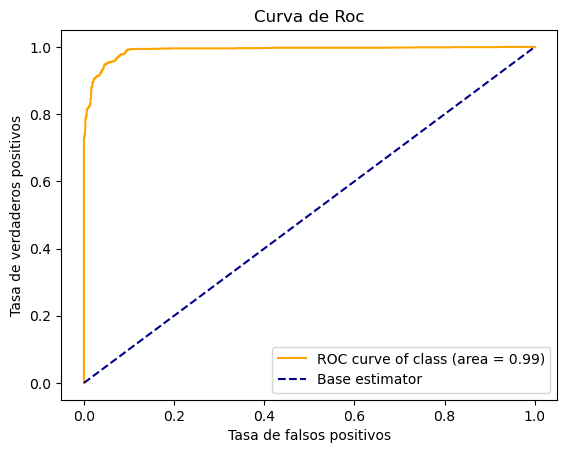

In [64]:
fpr, tpr, thresholds = roc_curve(y_test, GBoost.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

print("AUC: ", roc_auc)
plot_roc_curve(fpr, tpr, roc_auc)

In [63]:
dump(GBoost, 'GBoost.joblib') 

['GBoost.joblib']

## 9.5 Deep learning

Deep learning es un subconjunto de machine learning (que a su vez es parte de la inteligencia artificial) donde las redes neuronales, algoritmos inspirados en cómo funciona el cerebro humano, aprenden de grandes cantidades de datos y son el fundamento de esta disciplina.
Utilizamos el perceptrón multicapa (MLP), que es una red neuronal de avance con al menos 1 capa entre la capa de entrada y la de salida. Los datos se entrenan desde la capa de entrada hasta la capa de salida.

## 9.5.1 Redes de neuronas 

In [78]:
input_dim = X_train.shape[1]


In [79]:
model = Sequential() #creamos un modelo vació de tipo Secuencial.
#Este modelo se refiere a que crearemos una serie de capas de neuronas secuenciales, “una delante de otra”
model.add(Dense(units = 32, input_dim=input_dim, activation = "relu")) #units = neuronas
model.add(Dense(units = 64, activation = "relu"))
model.add(Dense(units = 128, activation = "relu"))
model.add(Dense(units = 256, activation = "relu"))
model.add(Dropout(0.4)) 
#Regularizacion-->Se opta por Dropout
#El proceso consiste en desactivar aleatoriamente una serie de neuronas durante el proceso de entrenamiento. 
#En concreto, durante cada iteración del entrenamiento, se ponen a cero los pesos de una fracción aleatoria de neuronas por capa

model.add(Dense(units = 64, activation = "relu"))
model.add(Dense(units = 32, activation = "relu"))
model.add(Dense(units = 64, activation = "relu"))
model.add(Dense(units = 32, activation = "relu"))

# Capa de salida --> función de activación sigmoide en la capa de salida por ser un modelo de clasificación binaria
model.add(Dense(units = 1, activation = "sigmoid"))


Antes de de entrenar la red haremos unos ajustes a nuestro modelo:
En este caso, utilizaremos la pérdida logarítmica, que para un problema de clasificación binaria se define en Keras como “binary_crossentropy”. También utilizaremos el optimizador “adam” por su alta eficiencia en estos problemas.

In [80]:
#Con esto indicamos el tipo de pérdida (loss) que utilizaremos, el “optimizador” de los pesos de las conexiones de las neuronas
#y las métricas que queremos obtener. 
model.compile( 
              loss = "binary_crossentropy", 
              optimizer = 'adam',
              metrics = (['binary_accuracy'],
                        [tf.keras.metrics.FalseNegatives()],
                        [tf.keras.metrics.Recall()]))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 32)                256       
                                                                 
 dense_19 (Dense)            (None, 64)                2112      
                                                                 
 dense_20 (Dense)            (None, 128)               8320      
                                                                 
 dense_21 (Dense)            (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                16448     
                                                                 
 dense_23 (Dense)            (None, 32)               

In [81]:
#Early Stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode='min', verbose=1 )

Entrenamos la red

In [82]:
historico = model.fit(X_train, y_train,validation_data=(X_test,y_test), batch_size = 50 , epochs = 25,callbacks=[callback],validation_split=0.2, verbose=1)



Epoch 1/25
263/263 [==============================] - 3s 4ms/step - loss: 0.3254 - binary_accuracy: 0.8617 - false_negatives_2: 1089.0000 - recall_2: 0.8341 - val_loss: 0.2195 - val_binary_accuracy: 0.9047 - val_false_negatives_2: 80.0000 - val_recall_2: 0.9514
Epoch 2/25
263/263 [==============================] - 1s 5ms/step - loss: 0.1957 - binary_accuracy: 0.9167 - false_negatives_2: 616.0000 - recall_2: 0.9062 - val_loss: 0.1818 - val_binary_accuracy: 0.9278 - val_false_negatives_2: 38.0000 - val_recall_2: 0.9769
Epoch 2: early stopping


In [83]:
# Evaluemos el modelo

print("Accuracy: %.2f" % model.evaluate(X_test, y_test, verbose=0)[1])

print("Recall: %.2f" % model.evaluate(X_test, y_test, verbose=0)[3])

print("Falsos negativos Test: %.2f" % model.evaluate(X_test, y_test, verbose=0)[2])

Accuracy: 0.93
Recall: 0.98
Falsos negativos Test: 38.00


In [84]:
recall_red = model.evaluate(X_test, y_test, verbose=0)[3]

In [85]:
model.save('C:\Documents\Python Scripts.h5')

## 10. Comparamos los resultados de los modelos desarrollados 

In [86]:
data = {'Modelo':['KNN','Random Forest','XGBOOST','Redes Neuronales'],
        'Recall':[recall_knn,recall_rf,recall_xg,recall_red],
        'Falsos Negativos': ['49', '185', '73', '38']
        }

In [87]:
data1 = pd.DataFrame(data)


In [88]:
data1.sort_values(by='Recall', ascending=False)

,Modelo,Recall,Falsos Negativos
3,Redes Neuronales,0.976900,38
0,KNN,0.970213,49
2,XGBOOST,0.955623,73
1,Random Forest,0.887538,185


## 11. Aplicamos los modelos de detección de fraude a los datos en producción no etiquetados y generamos un archivo con las predicciones de cada uno de los modelos. 
Este archivo debe poseer la siguiente información: identificador de la transferencia y resultado de la predicción (si es fraudulenta o no).

## 11.1 Cargamos el dataset con los fraudes a predecir

In [127]:
a_predecir = pd.read_csv("fraudes_a_predecir.csv") 

In [128]:
a_predecir.head(4)

,t_id,tipo,fecha_final,id_cliente_origen,balance_prev_origen,balance_post_origen,id_cliente_destino,balance_prev_destino,balance_post_destino,cuantia,mensaje_alarma,es_fraude
0,1200,TRANSFER,2022-09-01 08:00:00,C1366722422,0.00,0.00,C2083562754,763134.49,1186556.81,424141.36,NaN,NaN
1,156083,CASH_OUT,2022-09-01 19:00:00,C554058441,438.00,0.00,C1620029891,7992405.59,8198842.17,206436.59,NaN,NaN
2,160160,PAYMENT,2022-09-01 19:00:00,C1829190420,0.00,0.00,M1542648727,0.00,0.00,12185.20,NaN,NaN
3,217179,CASH_IN,2022-09-01 20:00:00,C649079159,14441449.12,14624800.35,C580961280,542893.81,467905.16,183351.24,NaN,NaN


## 11.2 Aplicamos las mismas transformaciones que a nuestros modelos 

In [129]:
filtro = (a_predecir['tipo'] == 'TRANSFER') | (a_predecir['tipo']  == 'CASH_OUT')

In [130]:
df_fraude =  a_predecir[filtro]

In [131]:
df_fraude.count()

t_id                    49
tipo                    49
fecha_final             49
id_cliente_origen       49
balance_prev_origen     49
balance_post_origen     49
id_cliente_destino      49
balance_prev_destino    49
balance_post_destino    49
cuantia                 49
mensaje_alarma           0
es_fraude                0
dtype: int64

In [132]:
ID = df_fraude['t_id']

In [133]:
df_fraude['diff_origen'] = abs(df_fraude['balance_post_origen']-df_fraude['balance_prev_origen'].astype(int))

In [134]:
df_fraude['diff_destino'] = abs(df_fraude['balance_post_destino']-df_fraude['balance_prev_destino'].astype(int))

In [136]:
df_fraude1 = df_fraude.drop(['id_cliente_origen','id_cliente_destino','fecha_final', 'mensaje_alarma',
                                             'balance_post_origen', 'balance_prev_destino','es_fraude','t_id'], axis=1)

In [138]:
df_fraude2 = pd.get_dummies(df_fraude1) 

In [139]:
df_fraude2.head()

,balance_prev_origen,balance_post_destino,cuantia,diff_origen,diff_destino,tipo_CASH_OUT,tipo_TRANSFER
0,0.0,1186556.81,424141.36,0.0,423422.81,0,1
1,438.0,8198842.17,206436.59,438.0,206437.17,1,0
5,0.0,2796844.45,1205911.79,0.0,1406049.45,0,1
6,0.0,2889608.83,40549.48,0.0,40549.83,1,0
7,0.0,681336.38,296354.62,0.0,296355.38,1,0


In [141]:
#Estandarizamos las columnas numericas 
col_names=['balance_prev_origen', 'balance_post_destino', 'cuantia', 'diff_origen',
       'diff_destino']
features_train = df_fraude2[col_names]
scaler = StandardScaler().fit(features_train.values)
features_train = scaler.transform(features_train.values)
df_fraude2[col_names] = features_train


## 11.3 Cargamos el modelo KNN que guardamos y predecimos 

In [143]:
KNN = load('knn.joblib')
prediccion_knn = KNN.predict(df_fraude2) #devuelve los t_id en orden 

In [144]:
df_knn = pd.DataFrame(data=ID.values, columns=['t_id'])

In [145]:
df_knn 

,t_id
0,1200
1,156083
2,318471
3,330446
4,399390
5,472486
6,533676
7,543910
8,601322
9,876335


In [146]:
df_knn['es_fraude'] = prediccion_knn


In [147]:
df_knn

,t_id,es_fraude
0,1200,0
1,156083,0
2,318471,0
3,330446,0
4,399390,0
5,472486,0
6,533676,0
7,543910,0
8,601322,0
9,876335,0


In [160]:
filtro2 = (a_predecir['tipo']  == 'DEBIT') | (a_predecir['tipo']  == 'CASH_IN')  | (a_predecir['tipo']  == 'PAYMENT')   

In [161]:
df_fraude3 =  a_predecir[filtro2]

In [163]:
ID3 = df_fraude3['t_id']

In [164]:
ID3 = pd.DataFrame(data=ID3.values, columns=['t_id'])

In [166]:
final_knn = df_knn.merge(ID3, how='outer', on = ['t_id'])

In [168]:
final_knn.fillna({'es_fraude': 0 }, inplace=True)

In [169]:
final_knn = pd.DataFrame(data = final_knn , columns=['t_id','es_fraude'])

In [171]:
final_knn['es_fraude'] = final_knn['es_fraude'].astype(int)

In [177]:
final_knn.head(25)

,t_id,es_fraude
0,1200,0
1,156083,0
2,318471,0
3,330446,0
4,399390,0
5,472486,0
6,533676,0
7,543910,0
8,601322,0
9,876335,0


In [174]:
final_knn.shape

(100, 2)

In [178]:
final_knn.to_csv('predicciones_knn.csv', index = False)

## 11.4 Cargamos el modelo Random forest que guardamos y predecimos

In [179]:
RF = load('knn.joblib')
prediccion_rf = RF.predict(df_fraude2)

In [180]:
df_rf = pd.DataFrame(data=ID.values, columns=['t_id'])

In [181]:
df_rf['es_fraude'] = prediccion_rf

In [182]:
final_rf = df_rf.merge(ID3, how='outer', on = ['t_id'])

In [183]:
final_rf.fillna({'es_fraude': 0 }, inplace=True)

In [184]:
final_rf = pd.DataFrame(data = final_rf , columns=['t_id','es_fraude'])

In [185]:
final_rf['es_fraude'] = final_rf['es_fraude'].astype(int)

In [189]:
final_rf.shape

(100, 2)

In [190]:
final_rf.to_csv('predicciones_Random_forest.csv', index = False)

## 11.5 Cargamos el modelo XGBoost que guardamos y predecimos

In [191]:
GB = load('GBoost.joblib')

In [192]:
prediccion_GBoost = GB.predict(df_fraude2)

In [193]:
df_gb = pd.DataFrame(data=ID.values, columns=['t_id'])

In [194]:
df_gb['es_fraude'] = prediccion_GBoost

In [195]:
final_gb = df_gb.merge(ID3, how='outer', on = ['t_id'])

In [196]:
final_gb.fillna({'es_fraude': 0 }, inplace=True)

In [197]:
final_gb = pd.DataFrame(data = final_gb , columns=['t_id','es_fraude'])

In [198]:
final_gb['es_fraude'] = final_gb['es_fraude'].astype(int)

In [202]:
final_gb.shape

(100, 2)

In [203]:
final_gb.to_csv('predicciones_GBoost.csv', index = False)

## 11.6 Cargamos el modelo de Redes neuronales que guardamos y predecimos

In [204]:
red = keras.models.load_model('C:\Documents\Python Scripts.h5')

In [205]:
prediccion_red = red.predict(df_fraude2)

2/2 [==============================] - 0s 0s/step


In [206]:
df_red = pd.DataFrame(data=ID.values, columns=['t_id'])

In [207]:
df_red['es_fraude'] = prediccion_red 

In [208]:
final_red = df_red.merge(ID3, how='outer', on = ['t_id'])

In [209]:
final_red.fillna({'es_fraude': 0 }, inplace=True)

In [210]:
final_red = pd.DataFrame(data = final_red , columns=['t_id','es_fraude'])

In [211]:
final_red['es_fraude'] = final_red['es_fraude'].astype(int)

In [213]:
final_red.shape

(100, 2)

In [214]:
final_red.to_csv('predicciones_red.csv', index = False)

## by Maria Belen Camandone